# Unfairness Demo

This notebook is a demonstration of how unfairness can be propagated by ML models. I used the COMPASS dataset on [kaggle](https://www.kaggle.com/datasets/danofer/compass) to train a model (a Random Forest Regressor) to predict the decile score for a candidate. Ethnicity was one of the parameters used for training the model. My intent is to showcase how choosing an unfair model for decision-making in a consequential scenario can be very dangerous.

## Setting up the environment

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)

## Importing and viewing the data

In [3]:
df = pd.read_csv("./dataset/compas-scores-raw.csv")
df.head()

,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet_ID,ScaleSet,AssessmentReason,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0


In [4]:
potential_features = ["Sex_Code_Text", "Ethnic_Code_Text", "CustodyStatus", "DateOfBirth", "Screening_Date", "MaritalStatus", "RecSupervisionLevel"]
target = "DecileScore"

In [5]:
df[potential_features]

,Sex_Code_Text,Ethnic_Code_Text,CustodyStatus,DateOfBirth,Screening_Date,MaritalStatus,RecSupervisionLevel
0,Male,Caucasian,Jail Inmate,12/05/92,1/1/13 0:00,Single,1
1,Male,Caucasian,Jail Inmate,12/05/92,1/1/13 0:00,Single,1
2,Male,Caucasian,Jail Inmate,12/05/92,1/1/13 0:00,Single,1
3,Male,Caucasian,Jail Inmate,09/16/84,1/1/13 0:00,Married,1
4,Male,Caucasian,Jail Inmate,09/16/84,1/1/13 0:00,Married,1
...,...,...,...,...,...,...,...
60838,Male,African-American,Jail Inmate,06/21/64,12/31/14 0:00,Single,3
60839,Male,African-American,Jail Inmate,06/21/64,12/31/14 0:00,Single,3
60840,Male,Caucasian,Jail Inmate,02/06/85,12/31/14 0:00,Single,1
60841,Male,Caucasian,Jail Inmate,02/06/85,12/31/14 0:00,Single,1


## Pre-processing the data

In [6]:
def dobToAge(dob: str, ref: str) -> int: # date in MM/dd/yy ref in MM/dd/yy H:mm format
    mm, dd, yy = dob.split("/")
    yy = int(yy)

    pivot = 20
    
    if yy > pivot:
        yyyy = 1900 + yy
    else:
        yyyy = 2000 + yy

    dob = pd.to_datetime(f"{yyyy}-{mm}-{dd}")

    mm, dd, yy = ref.split(" ")[0].split("/")
    yy = int(yy)
    if len(mm) == 1:
        mm = "0" + mm
    if len(dd) == 1:
        dd = "0" + dd
    
    if yy > pivot:
        yyyy = 1900 + yy
    else:
        yyyy = 2000 + yy

    ref = pd.to_datetime(f"{yyyy}-{mm}-{dd}")

    return (ref.year - dob.year) - ((ref.month, ref.day) < (dob.month, dob.day))

In [7]:
def makeAge(dob_series: pd.Series, ref_series: pd.Series) -> pd.Series:
    age_arr = np.zeros(len(dob_series), dtype=np.int64)
    for i, (dob, ref) in enumerate(zip(dob_series, ref_series)):
        age_arr[i] = dobToAge(dob, ref)
    return pd.Series(age_arr, name="Age")

In [8]:
age_series = makeAge(df["DateOfBirth"], df["Screening_Date"])
age_series

0        20
1        20
2        20
3        28
4        28
         ..
60838    50
60839    50
60840    29
60841    29
60842    29
Name: Age, Length: 60843, dtype: int64

In [9]:
potential_features = ["Sex_Code_Text", "Ethnic_Code_Text", "CustodyStatus", "Age", "MaritalStatus", "RecSupervisionLevel"]

In [10]:
df_with_ages = pd.concat([df, age_series], axis=1)
df_with_ages[potential_features]

,Sex_Code_Text,Ethnic_Code_Text,CustodyStatus,Age,MaritalStatus,RecSupervisionLevel
0,Male,Caucasian,Jail Inmate,20,Single,1
1,Male,Caucasian,Jail Inmate,20,Single,1
2,Male,Caucasian,Jail Inmate,20,Single,1
3,Male,Caucasian,Jail Inmate,28,Married,1
4,Male,Caucasian,Jail Inmate,28,Married,1
...,...,...,...,...,...,...
60838,Male,African-American,Jail Inmate,50,Single,3
60839,Male,African-American,Jail Inmate,50,Single,3
60840,Male,Caucasian,Jail Inmate,29,Single,1
60841,Male,Caucasian,Jail Inmate,29,Single,1


In [11]:
categorical_features = [f for f in df_with_ages[potential_features].columns if df_with_ages.dtypes[f] == "object"]
categorical_features

['Sex_Code_Text', 'Ethnic_Code_Text', 'CustodyStatus', 'MaritalStatus']

In [12]:
df_with_ages[categorical_features]

,Sex_Code_Text,Ethnic_Code_Text,CustodyStatus,MaritalStatus
0,Male,Caucasian,Jail Inmate,Single
1,Male,Caucasian,Jail Inmate,Single
2,Male,Caucasian,Jail Inmate,Single
3,Male,Caucasian,Jail Inmate,Married
4,Male,Caucasian,Jail Inmate,Married
...,...,...,...,...
60838,Male,African-American,Jail Inmate,Single
60839,Male,African-American,Jail Inmate,Single
60840,Male,Caucasian,Jail Inmate,Single
60841,Male,Caucasian,Jail Inmate,Single


In [13]:
df_with_ages["Ethnic_Code_Text"] = df_with_ages["Ethnic_Code_Text"].replace("African-Am", "African-American")

In [14]:
for feature in categorical_features:
    print(f"{feature}: {df_with_ages[feature].unique()}")

Sex_Code_Text: ['Male' 'Female']
Ethnic_Code_Text: ['Caucasian' 'African-American' 'Hispanic' 'Other' 'Asian'
 'Native American' 'Oriental' 'Arabic']
CustodyStatus: ['Jail Inmate' 'Probation' 'Pretrial Defendant' 'Residential Program'
 'Prison Inmate' 'Parole']
MaritalStatus: ['Single' 'Married' 'Significant Other' 'Divorced' 'Separated' 'Widowed'
 'Unknown']


In [15]:
custody_status_order = ['Pretrial Defendant','Jail Inmate','Prison Inmate','Parole','Probation','Residential Program']
custody_status_mapper = {k: v for v, k in enumerate(custody_status_order)}
custody_status_mapper

{'Pretrial Defendant': 0,
 'Jail Inmate': 1,
 'Prison Inmate': 2,
 'Parole': 3,
 'Probation': 4,
 'Residential Program': 5}

In [16]:
df_with_ages["CustodyStatus"] = df_with_ages["CustodyStatus"].map(custody_status_mapper)

In [17]:
nominal_features = ["Sex_Code_Text", "Ethnic_Code_Text", "MaritalStatus"]

In [18]:
ordinal_features = ["CustodyStatus"]

In [19]:
numerical_features = ["Age", "RecSupervisionLevel"] 

In [20]:
df_with_ages = df_with_ages[nominal_features + ordinal_features + numerical_features + [target]]
df_with_ages

,Sex_Code_Text,Ethnic_Code_Text,MaritalStatus,CustodyStatus,Age,RecSupervisionLevel,DecileScore
0,Male,Caucasian,Single,1,20,1,4
1,Male,Caucasian,Single,1,20,1,2
2,Male,Caucasian,Single,1,20,1,1
3,Male,Caucasian,Married,1,28,1,2
4,Male,Caucasian,Married,1,28,1,1
...,...,...,...,...,...,...,...
60838,Male,African-American,Single,1,50,3,8
60839,Male,African-American,Single,1,50,3,10
60840,Male,Caucasian,Single,1,29,1,2
60841,Male,Caucasian,Single,1,29,1,5


In [21]:
dummies = pd.get_dummies(df_with_ages[nominal_features], drop_first=True, dtype=pd.Int64Dtype())
dummies

,Sex_Code_Text_Male,Ethnic_Code_Text_Arabic,Ethnic_Code_Text_Asian,Ethnic_Code_Text_Caucasian,Ethnic_Code_Text_Hispanic,Ethnic_Code_Text_Native American,Ethnic_Code_Text_Oriental,Ethnic_Code_Text_Other,MaritalStatus_Married,MaritalStatus_Separated,MaritalStatus_Significant Other,MaritalStatus_Single,MaritalStatus_Unknown,MaritalStatus_Widowed
0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
1,1,0,0,1,0,0,0,0,0,0,0,1,0,0
2,1,0,0,1,0,0,0,0,0,0,0,1,0,0
3,1,0,0,1,0,0,0,0,1,0,0,0,0,0
4,1,0,0,1,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60838,1,0,0,0,0,0,0,0,0,0,0,1,0,0
60839,1,0,0,0,0,0,0,0,0,0,0,1,0,0
60840,1,0,0,1,0,0,0,0,0,0,0,1,0,0
60841,1,0,0,1,0,0,0,0,0,0,0,1,0,0


In [22]:
df_final = pd.concat([df_with_ages[ordinal_features], dummies, df_with_ages[numerical_features], df_with_ages[target]], axis=1)
df_final

,CustodyStatus,Sex_Code_Text_Male,Ethnic_Code_Text_Arabic,Ethnic_Code_Text_Asian,Ethnic_Code_Text_Caucasian,Ethnic_Code_Text_Hispanic,Ethnic_Code_Text_Native American,Ethnic_Code_Text_Oriental,Ethnic_Code_Text_Other,MaritalStatus_Married,MaritalStatus_Separated,MaritalStatus_Significant Other,MaritalStatus_Single,MaritalStatus_Unknown,MaritalStatus_Widowed,Age,RecSupervisionLevel,DecileScore
0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,20,1,4
1,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,20,1,2
2,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,20,1,1
3,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,28,1,2
4,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,28,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60838,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,50,3,8
60839,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,50,3,10
60840,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,29,1,2
60841,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,29,1,5


In [23]:
features = ordinal_features + list(dummies.columns) + numerical_features
features

['CustodyStatus',
 'Sex_Code_Text_Male',
 'Ethnic_Code_Text_Arabic',
 'Ethnic_Code_Text_Asian',
 'Ethnic_Code_Text_Caucasian',
 'Ethnic_Code_Text_Hispanic',
 'Ethnic_Code_Text_Native American',
 'Ethnic_Code_Text_Oriental',
 'Ethnic_Code_Text_Other',
 'MaritalStatus_Married',
 'MaritalStatus_Separated',
 'MaritalStatus_Significant Other',
 'MaritalStatus_Single',
 'MaritalStatus_Unknown',
 'MaritalStatus_Widowed',
 'Age',
 'RecSupervisionLevel']

In [24]:
X = df_final[features]
y = df_final[target]

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [26]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((48674, 17), (12169, 17), (48674,), (12169,))

In [ ]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
mms.fit(X_train)
X_train_scaled = mms.transform(X_train)
X_test_scaled = mms.transform(X_test)

## Training the model

In [28]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=101, n_estimators=200)
model.fit(X_train_scaled, y_train)

,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Testing the model

In [29]:
y_pred = model.predict(X_test_scaled)

In [30]:
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(y_test, y_pred)

1.9554585280777497

In [31]:
study_result = pd.concat([df_with_ages.loc[X_test.index].drop("DecileScore", axis=1), pd.Series(y_pred, index=X_test.index, name="DecileScore")], axis=1)
study_result

,Sex_Code_Text,Ethnic_Code_Text,MaritalStatus,CustodyStatus,Age,RecSupervisionLevel,DecileScore
58221,Female,Caucasian,Single,1,46,1,2.191882
12959,Male,Caucasian,Single,1,50,1,2.130978
21864,Male,African-American,Single,1,23,3,5.915055
32319,Male,African-American,Single,4,28,1,2.721474
16518,Male,Hispanic,Single,4,47,1,1.394714
...,...,...,...,...,...,...,...
57557,Male,African-American,Divorced,1,38,1,2.569344
48650,Male,Caucasian,Married,1,55,1,1.511432
21150,Male,African-American,Single,4,22,3,6.300566
524,Male,Caucasian,Married,4,36,2,5.056703


## Analysing the biases in the model's predictions

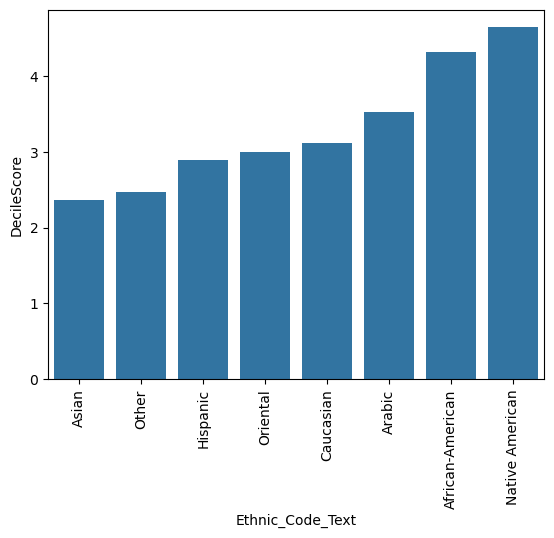

In [32]:
sns.barplot(study_result.groupby("Ethnic_Code_Text")["DecileScore"].mean().sort_values())
plt.xticks(rotation=90);

As we can see, the average decile score varies significantly with ethinicity. Hence there is a correlation between the ethnicity of a person and their decile score according to our model.  

In [33]:
template = pd.Series([ 1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0, 29,  1], 
          ['CustodyStatus', 'Sex_Code_Text_Male', 'Ethnic_Code_Text_Arabic',
       'Ethnic_Code_Text_Asian', 'Ethnic_Code_Text_Caucasian',
       'Ethnic_Code_Text_Hispanic', 'Ethnic_Code_Text_Native American',
       'Ethnic_Code_Text_Oriental', 'Ethnic_Code_Text_Other',
       'MaritalStatus_Married', 'MaritalStatus_Separated',
       'MaritalStatus_Significant Other', 'MaritalStatus_Single',
       'MaritalStatus_Unknown', 'MaritalStatus_Widowed', 'Age',
       'RecSupervisionLevel'])

template

CustodyStatus                        1
Sex_Code_Text_Male                   1
Ethnic_Code_Text_Arabic              0
Ethnic_Code_Text_Asian               0
Ethnic_Code_Text_Caucasian           0
Ethnic_Code_Text_Hispanic            0
Ethnic_Code_Text_Native American     0
Ethnic_Code_Text_Oriental            0
Ethnic_Code_Text_Other               0
MaritalStatus_Married                0
MaritalStatus_Separated              0
MaritalStatus_Significant Other      0
MaritalStatus_Single                 1
MaritalStatus_Unknown                0
MaritalStatus_Widowed                0
Age                                 29
RecSupervisionLevel                  1
dtype: int64

We are trying to see the impact of ethnicity on the prediction of decile score by predicting for two candidates having the exact same values for all the features except ethnicity.

In [34]:
# African-American candidate
afam = template.copy()
afam.name = "African-American"

In [35]:
# Asian candidate
asian = template.copy()
asian["Ethnic_Code_Text_Asian"] = 1
asian.name = "Asian"

In [36]:
test_candidates = pd.DataFrame([afam, asian])
test_candidates

,CustodyStatus,Sex_Code_Text_Male,Ethnic_Code_Text_Arabic,Ethnic_Code_Text_Asian,Ethnic_Code_Text_Caucasian,Ethnic_Code_Text_Hispanic,Ethnic_Code_Text_Native American,Ethnic_Code_Text_Oriental,Ethnic_Code_Text_Other,MaritalStatus_Married,MaritalStatus_Separated,MaritalStatus_Significant Other,MaritalStatus_Single,MaritalStatus_Unknown,MaritalStatus_Widowed,Age,RecSupervisionLevel
African-American,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,29,1
Asian,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,29,1


In [37]:
test_candidates_scaled = mms.transform(test_candidates)
test_results = model.predict(test_candidates_scaled)
test_results = pd.Series(test_results, index=test_candidates.index)
test_results

African-American    2.572922
Asian               1.969109
dtype: float64

So we can see two people having different decile scores purely because of their differences in ethnicities. If we used this model in real world, it would certainly lead to racial discrimination!